In [22]:
from ortools.sat.python import cp_model
import pandas as pd
import joblib
from datetime import timedelta
import matplotlib.pyplot as plt
import math

In [23]:
df = pd.read_csv(
    "data/test_input.csv",
    dtype={
        "imo": "int32",
        "company_name": "object",
        "ship_type": "object",
        "gt": "int64",
        "dwt": "int64",
        "length": "int64",
        "width": "int64",
        "age": "int64",
        "fuel_consumption": "float64",
    },
    parse_dates=["eta"]
)

model = joblib.load("models/trained.pkl")

features = [
    "gt", "dwt","length", "width", "age",
    "fuel_consumption",
    "ship_type","company_name",
    "median_time_in_port_hours",
    "tech_eff_index",
    "tech_eff_value",
]

df["pred_turnaround_h"] = model.predict(df[features])

EF_CO2 = 3.114
df["fuel_tph_alongside"] = df["fuel_consumption"] / 24 * 0.15
df["co2_rate_tph"] = df["fuel_tph_alongside"] * EF_CO2


In [24]:
B = 3

model = cp_model.CpModel()
time_unit_min = 10
gap_slots      = 2   # two 10-min slot buffer
horizon_start = df["eta"].min().floor("h")
horizon_end   = horizon_start + timedelta(
    hours=df["pred_turnaround_h"].sum() / B + 48
)

total_minutes = (horizon_end - horizon_start).total_seconds() / 60
horizon_slots = math.ceil(total_minutes / time_unit_min)

pres = {}    # pres[i,b] = BoolVar: “ship i uses berth b?”
start = {}   # start[i,b] = IntVar: berth‐start slot if pres==1
interval = {} # interval[i,b] = OptionalIntervalVar(start, dur, start + dur, pres)


for i, ship in df.iterrows():
    dur = int(ship["pred_turnaround_h"] * 60 / time_unit_min)
    eta_off = math.ceil(
        (ship["eta"] - horizon_start).total_seconds()
        / (60 * time_unit_min)
    )

    dur_slots = int(ship["pred_turnaround_h"] * 60 / time_unit_min)

    pres[i] = {}
    start[i] = {}
    interval[i] = {}
    for b in range(B):
        pres[i][b] = model.NewBoolVar(f"pres_s{i}_b{b}")

        start[i][b] = model.NewIntVar(
            eta_off, horizon_slots - dur_slots - gap_slots,
            f"start_s{i}_b{b}"
        )
        # extend interval by gap_slots for no-overlap
        interval[i][b] = model.NewOptionalIntervalVar(
            start[i][b],
            dur_slots + gap_slots,
            start[i][b] + dur_slots + gap_slots,
            pres[i][b],
            f"int_s{i}_b{b}"
        )

# Constraints definition
for i in pres:
    model.Add(sum(pres[i].values()) == 1)

for b in range(B):
    model.AddNoOverlap([interval[i][b]
                         for i in pres
                         if b in pres[i]])


In [25]:
# build the objective function
wait_penalty_hr  = 1000    # $/hour
co2_price_per_t  =  80     # $ per tonne CO₂

wait_penalty_slot = int(wait_penalty_hr * time_unit_min / 60)

wait_slots = {}
for i, ship in df.iterrows():
    wait_slots[i] = {}
    eta_off = math.ceil(
        (ship["eta"] - horizon_start).total_seconds()
        / (60 * time_unit_min)
    )
    for b in pres[i]:
        w = model.NewIntVar(0, horizon_slots, f"wait_s{i}_b{b}")
        wait_slots[i][b] = w
        model.Add(w == start[i][b] - eta_off).OnlyEnforceIf(pres[i][b])
        model.Add(w == 0).OnlyEnforceIf(pres[i][b].Not())

cii_score = {"A": 4, "B": 3, "C": 2, "D": 1, "E": 0}
cii_weight = 100

obj_terms = []
for i, ship in df.iterrows():
    co2_cost = int(ship["pred_turnaround_h"]
                   * ship.co2_rate_tph
                   * co2_price_per_t)

    score = cii_score.get(ship["cii_rating"], 0)

    for b in pres[i]:
        p = pres[i][b]
        # waiting cost: slots * $/slot
        obj_terms.append(wait_slots[i][b] * wait_penalty_slot)
        # eco cost: constant * bool
        obj_terms.append(co2_cost * p)
        # c) CII “bonus” → subtract to reward green ships
        #    (A=4 → −400, B=3 → −300, … E=0 → 0)
        obj_terms.append(- score * cii_weight * p)

model.Minimize(sum(obj_terms))

In [26]:
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 10
status = solver.Solve(model)
if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    raise RuntimeError("No feasible schedule found")

if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
    print("Solution found.")
    print("Schedule:")
    for i, ship in df.iterrows():
         if i in pres:
             for b in range(B):
                 if solver.Value(pres[i][b]):
                     start_time = horizon_start + timedelta(minutes=solver.Value(start[i][b]) * time_unit_min)
                     dur_slots = int(ship["pred_turnaround_h"] * 60 / time_unit_min)
                     end_time  = start_time + timedelta(minutes=dur_slots * time_unit_min)
                     wait_time = solver.Value(wait_slots[i][b]) * time_unit_min / 60
                     print(f"Ship {i} assigned to Berth {b}: Start={start_time.strftime('%Y-%m-%d %H:%M')}, End={end_time.strftime('%Y-%m-%d %H:%M')}, Wait={wait_time:.2f} hours")

    print(f"Objective value: {solver.ObjectiveValue()}")



Solution found.
Schedule:
Ship 0 assigned to Berth 2: Start=2025-05-18 06:30, End=2025-05-19 02:40, Wait=0.00 hours
Ship 1 assigned to Berth 0: Start=2025-05-18 07:20, End=2025-05-19 02:50, Wait=0.00 hours
Ship 2 assigned to Berth 1: Start=2025-05-18 08:00, End=2025-05-19 04:10, Wait=0.00 hours
Ship 3 assigned to Berth 2: Start=2025-05-19 22:50, End=2025-05-20 18:40, Wait=37.00 hours
Ship 4 assigned to Berth 2: Start=2025-05-19 03:00, End=2025-05-19 22:30, Wait=16.50 hours
Ship 5 assigned to Berth 2: Start=2025-05-20 19:00, End=2025-05-21 15:20, Wait=55.67 hours
Ship 6 assigned to Berth 1: Start=2025-05-19 04:30, End=2025-05-20 00:20, Wait=15.67 hours
Ship 7 assigned to Berth 1: Start=2025-05-20 00:40, End=2025-05-20 20:40, Wait=35.00 hours
Ship 8 assigned to Berth 0: Start=2025-05-19 23:00, End=2025-05-20 18:50, Wait=32.67 hours
Ship 9 assigned to Berth 0: Start=2025-05-19 03:10, End=2025-05-19 22:40, Wait=12.00 hours
Objective value: 231716.0


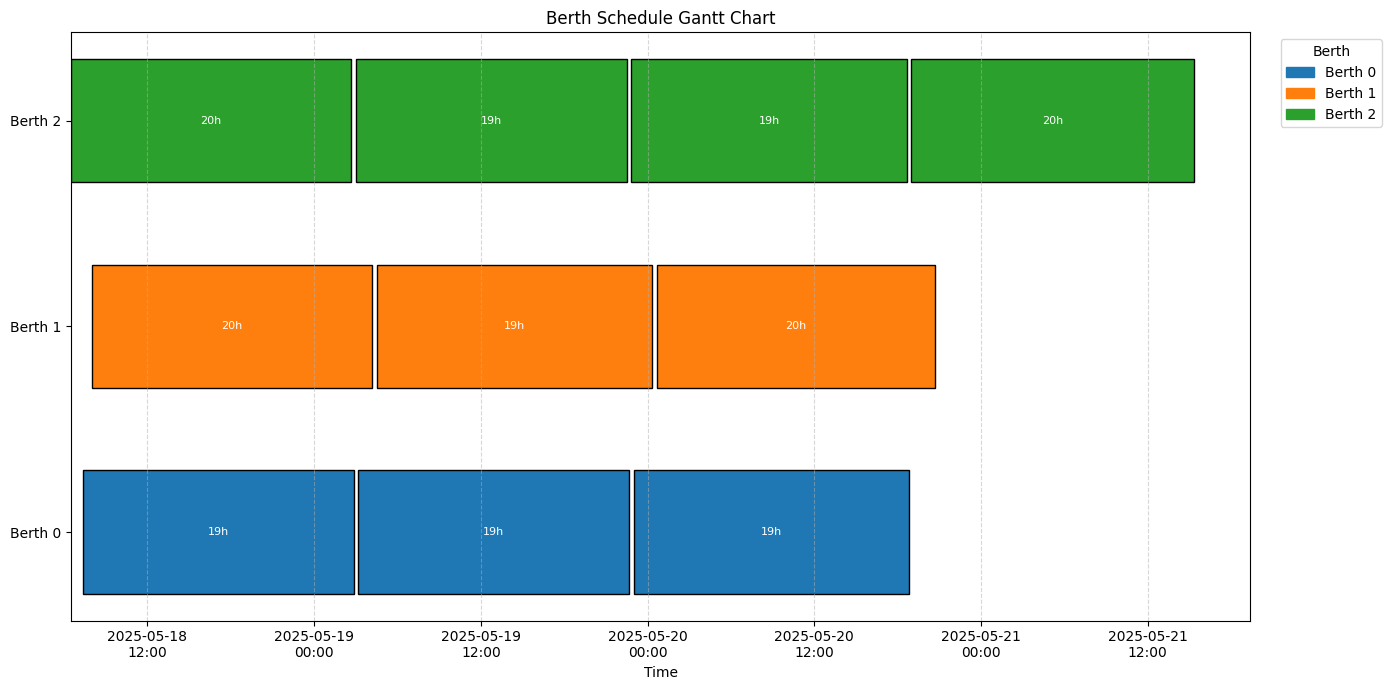

In [27]:
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
# Build DataFrame from solver variables
records = []
for i, ship in df.iterrows():
    for b, pvar in pres[i].items():
        if solver.Value(pvar):
            st_slot   = solver.Value(start[i][b])
            dur_slots = int(ship["pred_turnaround_h"] * 60 / time_unit_min)
            start_time = horizon_start + timedelta(minutes=st_slot * time_unit_min)
            end_time   = start_time + timedelta(minutes=dur_slots * time_unit_min)
            records.append({
                "imo":  ship["imo"],
                "berth": b,
                "start": start_time,
                "end":   end_time
            })

schedule_df = pd.DataFrame(records)

# 2) Prepare for Gantt plot
schedule_df["start_num"]     = mdates.date2num(schedule_df["start"])
schedule_df["duration_days"] = mdates.date2num(schedule_df["end"]) - schedule_df["start_num"]
berths = sorted(schedule_df["berth"].unique())
y_pos = {b: idx for idx, b in enumerate(berths)}
colors = plt.cm.tab10(range(len(berths)))

fig, ax = plt.subplots(figsize=(14, 7))

# 3) Plot bars and labels
for _, row in schedule_df.iterrows():
    y = y_pos[row["berth"]]
    ax.barh(y, row["duration_days"], left=row["start_num"], height=0.6,
            color=colors[y], edgecolor='k')
    dur_h = (row["end"] - row["start"]).total_seconds() / 3600
    ax.text(row["start_num"] + row["duration_days"]/2, y,
            f"{int(dur_h)}h", va='center', ha='center', color='white', fontsize=8)

# 4) Grid, legend, and formatting
ax.xaxis.grid(True, which='major', linestyle='--', alpha=0.5)
patches = [mpatches.Patch(color=colors[y_pos[b]], label=f"Berth {b}") for b in berths]
ax.legend(handles=patches, title="Berth", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_yticks(list(y_pos.values()))
ax.set_yticklabels([f"Berth {b}" for b in berths])
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
ax.set_xlabel("Time")
ax.set_title("Berth Schedule Gantt Chart")
plt.tight_layout()
plt.show()